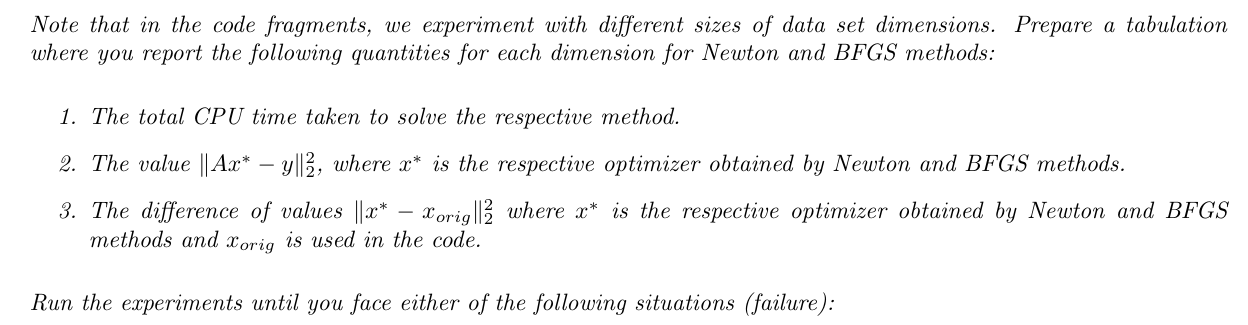

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker, cm
from math import sqrt, pi
from numpy import exp, cos, sin
from numpy.linalg import norm
import seaborn as sns
import time
import timeit

In [2]:
def fx(x, lamda):
  return 0.5*norm(A@x-y)**2 + 0.5*lamda*np.dot(x,x)

def grad_fx(x, lamda):
  return np.dot(A.transpose(), A)@x - A.transpose()@y + lamda*x

def hessian_fx(lamda):
  return A.transpose()@A + lamda*np.identity(A.shape[1])

def dk_fx(lamda):
  return np.linalg.inv(hessian_fx(lamda))

def get_alpha_bfgs(xk, alpha0, rho, gamma, Bk, lamda):
  alpha = alpha0
  pk = -grad_fx(xk, lamda)
  while fx(xk + alpha*Bk@pk, lamda) > (fx(xk, lamda) + gamma*alpha*grad_fx(xk, lamda)@Bk@pk):
    alpha = rho*alpha
  return alpha


def bfgs(x0, tau, alpha0, rho, gamma, lamda, max_iter=500):
  xk = np.copy(x0)
  n = len(x0)
  Bk = np.eye(n)
  count = 0
  pk = grad_fx(xk, lamda)
  xks = []
  xks.append(xk)
  while (norm(pk)>tau):
    if count > max_iter:
      break

    alpha = get_alpha_bfgs(xk, alpha0, rho, gamma, Bk, lamda)
    xnext = xk - alpha*(Bk@pk)

    # print("new xk: ", xk[0:5])
    ## new Bk+1 computation
    sk = xnext - xk
    yk = grad_fx(xnext, lamda) - grad_fx(xk, lamda)
    # BFGS update formula
    Bk = np.dot((np.eye(len(xk)) - np.outer(sk, yk) / np.dot(yk, sk)), np.dot(Bk, (np.eye(len(xk)) - np.outer(yk, sk) / np.dot(yk, sk)))) + np.outer(sk, sk) / np.dot(yk, sk)

    xk = xnext
    pk = grad_fx(xk, lamda)
    # print("grad is: ", pk[0:5])
    # print("grad norm is: ", norm(pk))
    xks.append(xk)
    count += 1

  return count, xk, fx(xk, lamda), xks

def get_alpha_newton(xk, alpha0, rho, gamma, Dk, lamda):
  alpha = alpha0
  pk = -grad_fx(xk, lamda)
  while fx(xk + alpha*Dk@pk, lamda) > (fx(xk, lamda) + gamma*alpha*grad_fx(xk, lamda)@Dk@pk):
    alpha = rho*alpha
  return alpha

def newton_method_with_backtracking(x0, tau, alpha0, rho, gamma, lamda):
  xk = np.copy(x0)
  count = 0
  pk = grad_fx(xk, lamda)
  xks = []
  xks.append(xk)
  while norm(pk)>tau:
    # print("Norm is: ", norm(pk))
    Dk = dk_fx(lamda)
    alpha = get_alpha_newton(xk, alpha0, rho, gamma, Dk, lamda)
    xk = xk - alpha*Dk@pk
    # print("xk is: ", xk)
    pk = grad_fx(xk, lamda)
    xks.append(xk)
    count += 1
  return count, xk, fx(xk, lamda), xks


In [3]:
np.random.seed(10) #for repeatability
N = 200
ds = [1000, 5000, 10000, 20000, 25000, 50000, 100000, 200000, 500000, 1000000]
lambda_reg = 0.001
eps = np.random.randn(N,1) #random noise

In [4]:
alpha0 = 0.99
rho = 0.5
gamma = 0.5
tau = 1e-5

In [ ]:
#For each value of dimension in the ds array, we will check the behavior of Newton method
for i in range(np.size(ds)):
  d=ds[i]
  A = np.random.randn(N,d)
  #Normalize the columns
  for j in range(A.shape[1]):
    A[:,j] = A[:,j]/np.linalg.norm(A[:,j])
  xorig = np.ones((d,1))
  y = np.dot(A,xorig) + eps
  y= y.flatten()
  start = timeit.default_timer()
  x0 = [0. for i in range(d)]
  count, minimizer, minimum, xks =  newton_method_with_backtracking(x0, tau, alpha0, rho, gamma, lambda_reg)
  newtontime = timeit.default_timer()- start #time is in seconds
  #print the total time and the L2 norm difference || x_opt- xorig|| for Newton method
  print("Dimensions: ", d)
  print("Iterations taken: ", count)
  print("Lambda is: 0.001")
  print("Time Taken: ", newtontime)
  print("||Ax*- y||^2  : ",norm(A@minimizer - y)**2)
  print("||x*- xorig||^2 :   ", (norm(minimizer - xorig.flatten()))**2)
  print("Minimizer (x*) is [printing only first few values]: ", minimizer[:10])
  print("Minimum is: ", minimum)
  print("Algo used is Newton with Backtracking")
  print("-------------------------------------------------------------------")

Dimensions:  1000
Iterations taken:  4
Lambda is: 0.001
Time Taken:  0.7270602140006304
||Ax*- y||^2  :  8.238408103442552e-05
||x*- xorig||^2 :    821.0785853624454
Minimizer (x*) is [printing only first few values]:  [ 1.87852068 -0.37678796  0.59513668 -0.26256277 -0.37345358  0.96932417
 -0.3595619   0.26957443  0.68659818  0.51560239]
Minimum is:  0.1450367820614685
Algo used is Newton with Backtracking
-------------------------------------------------------------------
Dimensions:  5000
Iterations taken:  4
Lambda is: 0.001
Time Taken:  56.537727240000095
||Ax*- y||^2  :  7.469114847468209e-06
||x*- xorig||^2 :    4831.556976889354
Minimizer (x*) is [printing only first few values]:  [ 0.07706986 -0.48387909 -0.25532519  0.0203297  -0.07296402  0.21172558
 -0.21182873  0.01047002 -0.00571822  0.30853442]
Minimum is:  0.08814449184053043
Algo used is Newton with Backtracking
-------------------------------------------------------------------
Dimensions:  10000
Iterations taken:  4

session ram crashed after 10000 dimensions.

In [6]:
#For each value of dimension in the ds array, we will check the behavior of BFGS method
for i in range(np.size(ds)):
  d=ds[i]
  A = np.random.randn(N,d)
  #Normalize the columns
  for j in range(A.shape[1]):
    A[:,j] = A[:,j]/np.linalg.norm(A[:,j])
  xorig = np.ones((d,1))
  y = np.dot(A,xorig) + eps
  y= y.flatten()
  start = timeit.default_timer()
  x0 = np.array([0. for i in range(d)])
  count, minimizer, minimum, xks =  bfgs(x0, tau, alpha0, rho, gamma, lambda_reg)
  bfgstime = timeit.default_timer()- start #time is in seconds
  #print the total time and the L2 norm difference || x_opt- xorig|| for Newton method
  print("Dimensions: ", d)
  print("Iterations taken: ", count)
  print("Lambda is: 0.001")
  print("Time Taken: ", bfgstime)
  print("||Ax*- y||^2  : ",norm(A@minimizer - y)**2)
  print("||x*- xorig||^2 :   ", (norm(minimizer - xorig.flatten()))**2)
  print("Minimizer (x*) is [printing only first few values]: ", minimizer[:10])
  print("Minimum is: ", minimum)
  print("Algo used is BFGS")
  print("-------------------------------------------------------------------")

Dimensions:  1000
Iterations taken:  32
Lambda is: 0.001
Time Taken:  9.530352511000274
||Ax*- y||^2  :  6.93326643072792e-05
||x*- xorig||^2 :    860.3322153960554
Minimizer (x*) is [printing only first few values]:  [ 0.62490926 -0.37187098  0.85414026  0.87765433 -0.59657931  0.82308941
  0.4902599  -0.08508701 -0.4015912   1.00827524]
Minimum is:  0.13057508153041256
Algo used is BFGS
-------------------------------------------------------------------
Dimensions:  5000
Iterations taken:  46
Lambda is: 0.001
Time Taken:  1048.732083545
||Ax*- y||^2  :  8.45137347674937e-06
||x*- xorig||^2 :    4814.771740447343
Minimizer (x*) is [printing only first few values]:  [ 0.09594043  0.06970346  0.20925264 -0.55215119  0.0063654   0.20923274
  0.18316178 -0.20548146  0.13519602  0.08906565]
Minimum is:  0.09934826956962658
Algo used is BFGS
-------------------------------------------------------------------


KeyboardInterrupt: 

After this code is taking more than 30 mins

$$
\begin{array}{|l|l|l|l|l|l|}
\hline
Dimensions & Iterations & CPU Time & ||Ax^* - y||_2^2 & ||x^* - xorig||_2^2 & Algo \ Used \\ \hline
1000& 4&0.727&8.23e-05&821.07& Newton \\ \hline
5000& 4&56.537&7.47e-06 &4831.55& Newton \\ \hline
10000& 4&413.131&4.50e-06&9778.87& Newton \\ \hline
1000& 32&9.530&6.933e-05&860.33& BFGS \\ \hline
5000& 40&1048.73&8.45e-06&4814.7& BFGS \\ \hline
\end{array}
$$


Dimension after which Newton fails is 10000, and 5000 for BFGS. We observe that, in Newton's case we get failure of RAM crash which is because the dimension of $A^TA$ becomes very high to hold these values and invert it. For BFGS, though the RAM usage is less, the time it is taking is long for more dimensions.